In [3]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
import pickle
from keras.regularizers import l2
from  scipy import ndimage

#### Dataset


Load dataset + One-hot encoding + Normalization

In [4]:
def load_dataset():
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # One-hot encoding
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    # Normalize to [0,1]
    trainX = trainX.astype('float32') / 255.0
    testX = testX.astype('float32') / 255.0

    return trainX, trainY, testX, testY

#### Model

Imortant functions

In [22]:
import math
class StepDecay(tf.keras.callbacks.Callback):

  def __init__(self, init_LR=0.1, factor=0.5, drop_epoch=10):
      super().__init__()
      # store the base initial learning rate, drop factor, and
      # epochs to drop every
      self.init_LR = init_LR
      self.factor = factor
      self.drop_epoch = drop_epoch


  def on_epoch_begin(self, epoch, logs=None):
      if not hasattr(self.model.optimizer, "lr"):
          raise ValueError('Optimizer must have a "lr" attribute.')
      # Get the current learning rate from model's optimizer.
      lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
      # Call schedule function to get the scheduled learning rate.
      new_lr = self.init_LR * math.pow(self.factor,math.floor((1+epoch)/self.drop_epoch))
      # Set the value back to the optimizer before this epoch starts
      tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
      print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, new_lr))

lr_step = StepDecay(init_LR = 0.1, factor = 0.5)
callbacks = [lr_step]

In [16]:
def train(model, trainX, trainY, testX, testY):
	generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

	train_data = generator.flow(trainX, trainY, batch_size=64)

	results = model.fit(train_data, epochs=100, validation_data=(testX, testY), verbose=1, callbacks=callbacks)

	return results

def evaluate(model, testX, testY):
    _, acc = model.evaluate(testX, testY, verbose=0)

    print(f"The model achieved a final accuracy of {acc*100:.2f}%")

def plot_results(history):
	plt.title('Cross Entropy Loss')
	plt.plot(history['loss'], color='blue', label='Training loss')
	plt.plot(history['val_loss'], color='orange', label='Validation/test loss')
	plt.legend()
	plt.show()

	plt.title('Classification Accuracy')
	plt.plot(history['accuracy'], color='blue', label='Training accuracy')
	plt.plot(history['val_accuracy'], color='orange', label='Validation/test accuracy')
	plt.legend()
	plt.show()

In [8]:
def save_model(filename, model):
    filename = '/content/models/' + filename
    pickle.dump(model, open(filename, 'wb'))

def save_history(filename, history):
    filename = '/content/history/' + filename
    pickle.dump(history, open(filename, 'wb'))

def load_model(filename):
    filename = '/content/models/' + filename
    model = pickle.load(open(filename, 'rb'))
    return model

def load_history(filename):
    filename = '/content/history/' + filename
    history = pickle.load(open(filename, 'rb'))
    return history

Baseline model

In [9]:
def dropout_model():
    # Create architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    init_lr = 0.1

    # Optimization method
    opt = SGD(learning_rate=init_lr, momentum=0.9)

    # Compile model and choose loss type
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
trainX, trainY, testX, testY = load_dataset()

170498071/170498071 [==============================] - 2s 0us/step


In [23]:
model = dropout_model()
results = train(model, trainX, trainY, testX, testY)


Epoch 00000: Learning rate is 0.1000.
Epoch 1/100
782/782 [==============================] - 42s 44ms/step - loss: 1.7439 - accuracy: 0.3694 - val_loss: 1.8917 - val_accuracy: 0.3782

Epoch 00001: Learning rate is 0.1000.
Epoch 2/100
782/782 [==============================] - 33s 42ms/step - loss: 1.3836 - accuracy: 0.5030 - val_loss: 1.0766 - val_accuracy: 0.6154

Epoch 00002: Learning rate is 0.1000.
Epoch 3/100
782/782 [==============================] - 33s 42ms/step - loss: 1.1832 - accuracy: 0.5795 - val_loss: 1.1432 - val_accuracy: 0.6184

Epoch 00003: Learning rate is 0.1000.
Epoch 4/100
782/782 [==============================] - 32s 41ms/step - loss: 1.0532 - accuracy: 0.6345 - val_loss: 0.8883 - val_accuracy: 0.6907

Epoch 00004: Learning rate is 0.1000.
Epoch 5/100
782/782 [==============================] - 33s 42ms/step - loss: 0.9708 - accuracy: 0.6632 - val_loss: 0.9747 - val_accuracy: 0.6747

Epoch 00005: Learning rate is 0.1000.
Epoch 6/100
782/782 [====================

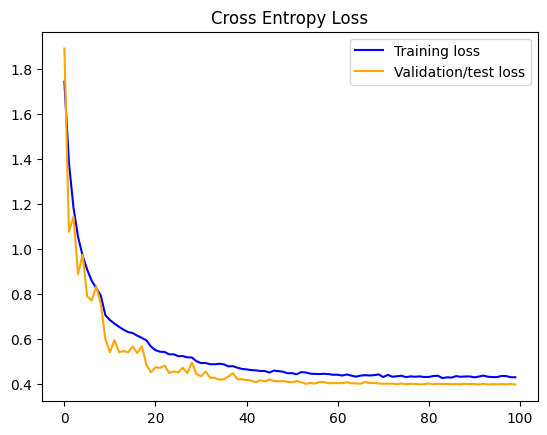

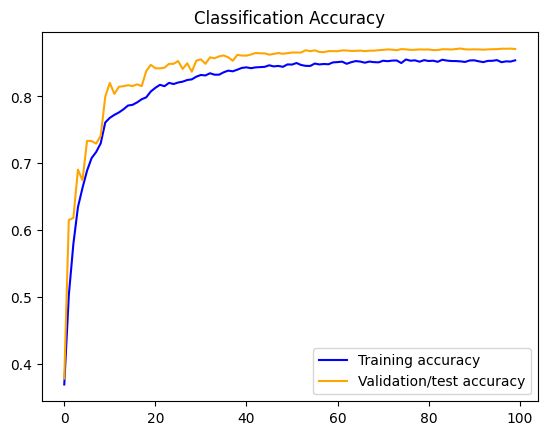

The model achieved a final accuracy of 87.09%


In [25]:
plot_results(results.history)
evaluate(model, testX, testY)

In [27]:
save_model('step_decay_model', model)
save_history('step_decay_model', results.history)

In [28]:
from google.colab import files
files.download('/content/models/step_decay_model')
files.download('/content/history/step_decay_model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
test = load_model('step_decay_model')
history_test = load_history('step_decay_model')

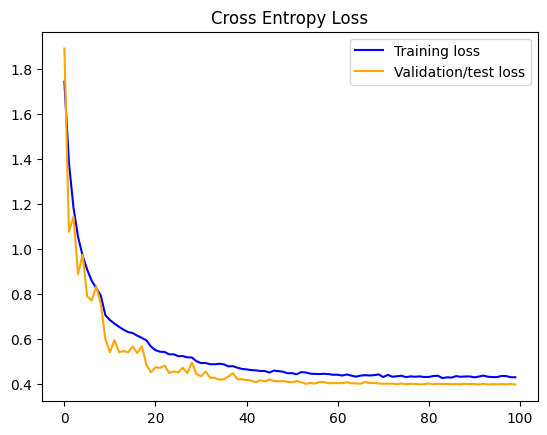

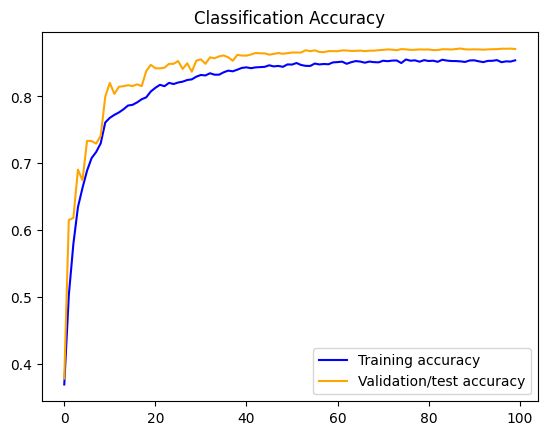

The model achieved a final accuracy of 87.09%


In [31]:
plot_results(history_test)
evaluate(test, testX, testY)